In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

from keras.datasets import mnist
from keras.layers import Dense, Input, BatchNormalization, Activation
from keras.layers import Conv2D, Conv2DTranspose, UpSampling2D, GlobalAveragePooling2D
from keras.layers import Reshape, Dropout, Flatten, LeakyReLU
from keras.activations import softmax
from keras.models import Sequential
from keras.optimizers import Adam
from keras import backend as K
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
# config.gpu_options.per_process_gpu_memory_fraction = 0.48
set_session(tf.Session(config=config))
K.get_session().run(tf.global_variables_initializer())
import time

Using TensorFlow backend.


In [2]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.reshape(60000,28,28,1)
X_test = X_test.reshape(10000,28,28,1)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

60000 train samples
10000 test samples


In [3]:
def build_discriminator():
    
    def build_classifier():
        dropout = 0.4
        model = Sequential()

        model.add(Conv2D(64,5,strides=2,input_shape=(28,28,1)))
        model.add(LeakyReLU(0.2))
        model.add(Dropout(dropout))

        model.add(Conv2D(128,5,strides=2,padding='same'))
        model.add(BatchNormalization(momentum=0.5))
        model.add(LeakyReLU(0.2))
        model.add(Dropout(dropout))

        model.add(Conv2D(256,5,strides=2,padding='same'))
        model.add(BatchNormalization(momentum=0.5))
        model.add(LeakyReLU(0.2))
        model.add(Dropout(dropout))

        model.add(Conv2D(512,5,strides=1,padding='same'))
        model.add(LeakyReLU(0.2))

        # global average pooling
        model.add(GlobalAveragePooling2D())
        model.add(Dense(10))
        model.add(Activation('softmax'))
        
        return model
    
    clf = build_classifier()
    model = Sequential()
    model.add(clf)
    
    return clf, model

In [4]:
def build_generator():
    dropout = 0.4
    model = Sequential()
    
    model.add(Dense(7*7*256,input_dim=100))
    model.add(BatchNormalization(momentum=0.5))
    model.add(Activation('relu'))
    model.add(Reshape((7,7,256)))
    model.add(Dropout(dropout))
    
    model.add(UpSampling2D())
    model.add(Conv2DTranspose(128,5,padding='same'))
    model.add(BatchNormalization(momentum=0.5))
    model.add(Activation('relu'))
    
    model.add(UpSampling2D())
    model.add(Conv2DTranspose(64,5,padding='same'))
    model.add(BatchNormalization(momentum=0.5))
    model.add(Activation('relu'))
    
    model.add(Conv2DTranspose(32,5,padding='same'))
    model.add(BatchNormalization(momentum=0.5))
    model.add(Activation('relu'))
    
    model.add(Conv2DTranspose(1,5,padding='same'))
    model.add(Activation('tanh'))
    
    return model

In [5]:
def build_gan(generator, discriminator):
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    return model

In [6]:
optimizer = Adam(lr=0.0002)
generator = build_generator()
classifier, discriminator = build_discriminator()
gan = build_gan(generator,discriminator)

classifier.compile(loss='sparse_categorical_crossentropy',
                   metrics=['acc'],
                   optimizer=optimizer)
discriminator.compile(loss='binary_crossentropy',
                      optimizer=optimizer)
discriminator.trainable = False
gan.compile(loss='binary_crossentropy',
            optimizer=optimizer)
discriminator.trainable = True

In [7]:
def mask(data, labels):
    n = len(data)
    label_rate = 0.2
    label_index = np.random.randint(n, size=int(n*label_rate))
    data_with_label = data[label_index]
    data_unlabel = data[~label_index]
    new_labels = labels[label_index]
    return data_with_label, data_unlabel, new_labels

In [14]:
def train(X, y, batch, epochs, classifier, discriminator, generator, gan):
    
    rounds = len(X) // batch
    for epoch in range(epochs):
        for rou in range(rounds + 1):
            if rou == rounds:
                data, labels = X[rou * batch:], y[rou * batch:]
            else:
                data, labels = X[rou * batch:(rou + 1) * batch], y[rou * batch:(rou + 1) * batch]
            if len(data) == 0:
                break
            labeled,  unlabeled, new_label = mask(data, labels)
            
            # train classifier with labeled data
            classifier.train_on_batch(labeled, new_label)
            
            # train discriminator on real unlabeled data
            ones = np.ones(len(unlabeled)) - 0.1
            discriminator.train_on_batch(unlabeled, ones)
            
            # create random noise for generator input 
            noise_size = len(data)
            noise = np.random.normal(size = (noise_size, 100))
            
            # train discriminator on fake data
            fake = generator.predict_on_batch(noise)
            zeros = np.zeros(noise_size)
            discriminator.train_on_batch(fake, zeros)
            
            discriminator.trainable = False
            ones = np.ones(noise_size)
            gan.train_on_batch(noise, ones)
            discriminator.trainable = True

In [15]:
initial = classifier.layers[0].get_weights()

In [16]:
epochs= 2
batch = 1000
t1 = time.time()
train(X_train, y_train, batch, epochs, classifier, discriminator, generator, gan)
print(time.time() - t1)

36.2731614112854


In [24]:
classifier.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 12, 12, 64)        1664      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 6, 6, 128)         204928    
_________________________________________________________________
batch_normalization_5 (Batch (None, 6, 6, 128)         512       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 6, 6, 128)         0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 6, 6, 128)         0         
__________

In [18]:
after = classifier.layers[0].get_weights()
after[0] == initial[0]

array([[[[ True,  True,  True, ...,  True,  True,  True]],

        [[ True,  True,  True, ...,  True,  True,  True]],

        [[ True,  True,  True, ...,  True,  True,  True]],

        [[ True,  True,  True, ...,  True,  True,  True]],

        [[ True,  True,  True, ...,  True,  True,  True]]],


       [[[ True,  True,  True, ...,  True,  True,  True]],

        [[ True,  True,  True, ...,  True,  True,  True]],

        [[ True,  True,  True, ...,  True,  True,  True]],

        [[ True,  True,  True, ...,  True,  True,  True]],

        [[ True,  True,  True, ...,  True,  True,  True]]],


       [[[ True,  True,  True, ...,  True,  True,  True]],

        [[ True,  True,  True, ...,  True,  True,  True]],

        [[ True,  True,  True, ...,  True,  True,  True]],

        [[ True,  True,  True, ...,  True,  True,  True]],

        [[ True,  True,  True, ...,  True,  True,  True]]],


       [[[ True,  True,  True, ...,  True,  True,  True]],

        [[ True,  True,  True, ...

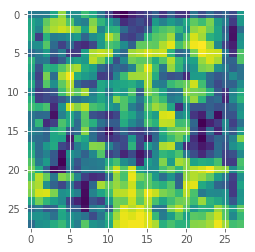

In [19]:
gen = generator.predict(np.random.normal(0,1,size=(1,100)))
plt.imshow(gen.reshape(28,28))

In [20]:
y_pred = classifier.predict(X_test)

In [21]:
y_test = y_test.reshape(-1,1)

In [22]:
(y_pred == y_test).sum()/len(y_test)

0.1135